In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
%%capture
import arcadia_pycolor as apc
from src.analysis.preprocess import *
from src.analysis.utils_jacobian import *

from umap_pytorch import PUMAP
import torch.nn.functional as F
from src.analysis.networks import deepReLUNet, deepSiLUNet, deepBilinearNet, BatchNormDetached

In [8]:
def init_data(t_cells=True):
    if t_cells:
        adata = preprocess_bone_marrow_dataset(n_pcs=50, full_preprocess=False)
        adata_subset1 = adata[adata.obs['cell_type'] == 'CD4+ T activated', :]
        adata_subset3 = adata[adata.obs['cell_type'] == 'CD4+ T naive', :]

        adata = ad.concat([adata_subset1,adata_subset3], label="T_cell_type")
        adata.obs_names_make_unique()

        adata = preprocess_bone_marrow_dataset(adata,n_pcs=50, full_preprocess=True)
    else:
        adata = preprocess_bone_marrow_dataset(adata,n_pcs=50, full_preprocess=True)
    # sc.pp.neighbors(adata, n_neighbors=15, n_pcs = 50, use_rep='X_pca')
    return adata

In [9]:
def fit(adata):
    train_dataset, adata_mean_zero = prepare_data(adata, pca_components=50)#,  pca_start=1)
    network = deepReLUNet(input_size=50,hidden_size=1024+128) # Replace with your model instantiation

    pumap = PUMAP(
        encoder=network,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=50,
        min_dist=0.75,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=12,
        lr=1e-4,
        epochs=64*1,
        batch_size=256*12,
        num_workers=2,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
    )

    # data = torch.randn((50000, 512))
    pumap.fit(train_dataset.squeeze())#

    return train_dataset, pumap

In [10]:
adata = init_data()

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


⚙️  Running initial preprocessing...
Initial preprocessing complete.
⚙️  Running initial preprocessing...
Initial preprocessing complete.
🔬 Running quality control...
Quality control complete.
🧹 Filtering data and detecting doublets...
Filtering and doublet detection complete.
⚖️  Normalizing data and selecting features...
Normalization and feature selection complete.
📉 Reducing dimensionality with PCA...
PCA complete.


In [12]:
train_dataset, pumap = fit(adata)

Preparing data for training...


/home/coder/glass-box-umap/src/analysis/utils_jacobian.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  train_dataset = torch.tensor([adata.obsm["X_pca"][:, pca_start:pca_components]], dtype=torch.float32)


 Data prepared with training shape: torch.Size([1, 12863, 50])
Fri Aug 22 19:47:53 2025 Building RP forest with 11 trees
Fri Aug 22 19:48:06 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations


/usr/local/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 63: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s, v_num=2, umap_loss=0.296]


Reducing array of shape torch.Size([12863, 50]) to (12863, 2)


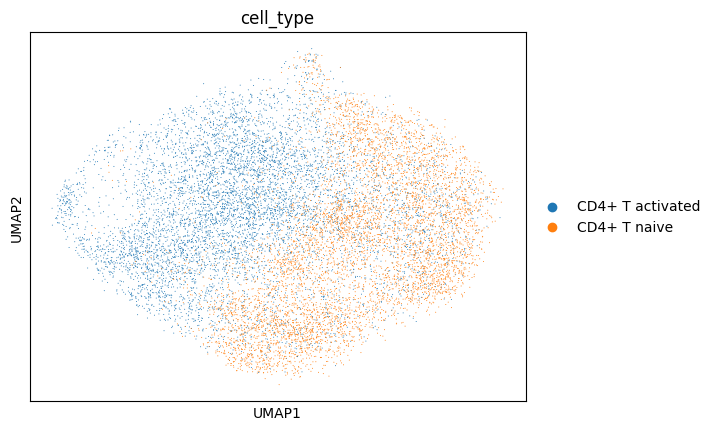

In [14]:
embedding = pumap.transform(train_dataset.squeeze())
adata.obsm['X_umap'] = embedding#encoder.model.encoder(train_dataset.squeeze()).squeeze().detach().cpu().numpy()
sc.pl.umap(adata, use_raw=False, color='cell_type',size=2,cmap = (apc.palettes.primary + apc.palettes.secondary).to_mpl_cmap())

In [17]:
%%time
from src.analysis.utils_jacobian import compute_gene_space_jacobian

adf = adata.to_df()
adfmz = adf.values - adf.mean(axis=0).values

# Step 4: Compute Jacobian in gene space
jacobxall = compute_gene_space_jacobian(pumap.encoder, adata, train_dataset, adfmz)#, jacobian_batch_size=40)#config["jacobian_batch_size"])


🧠 Computing Jacobian and projecting to gene space...
 Jacobian calculation complete.
CPU times: user 8min 57s, sys: 2.29 s, total: 8min 59s
Wall time: 1min 16s


🎨 Plotting feature importances for cell types...

Analyzing cell type: CD4+ T activated


/home/coder/glass-box-umap/src/analysis/utils_jacobian.py:197: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(embedding[is_cell_type, 0], embedding[is_cell_type, 1], c = category_colors[ci], s=3, marker='x',label=cell_type)
/home/coder/glass-box-umap/src/analysis/utils_jacobian.py:223: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(1*jx0_agg, 1*jx1_agg, s=4, c=category_colors[ci])


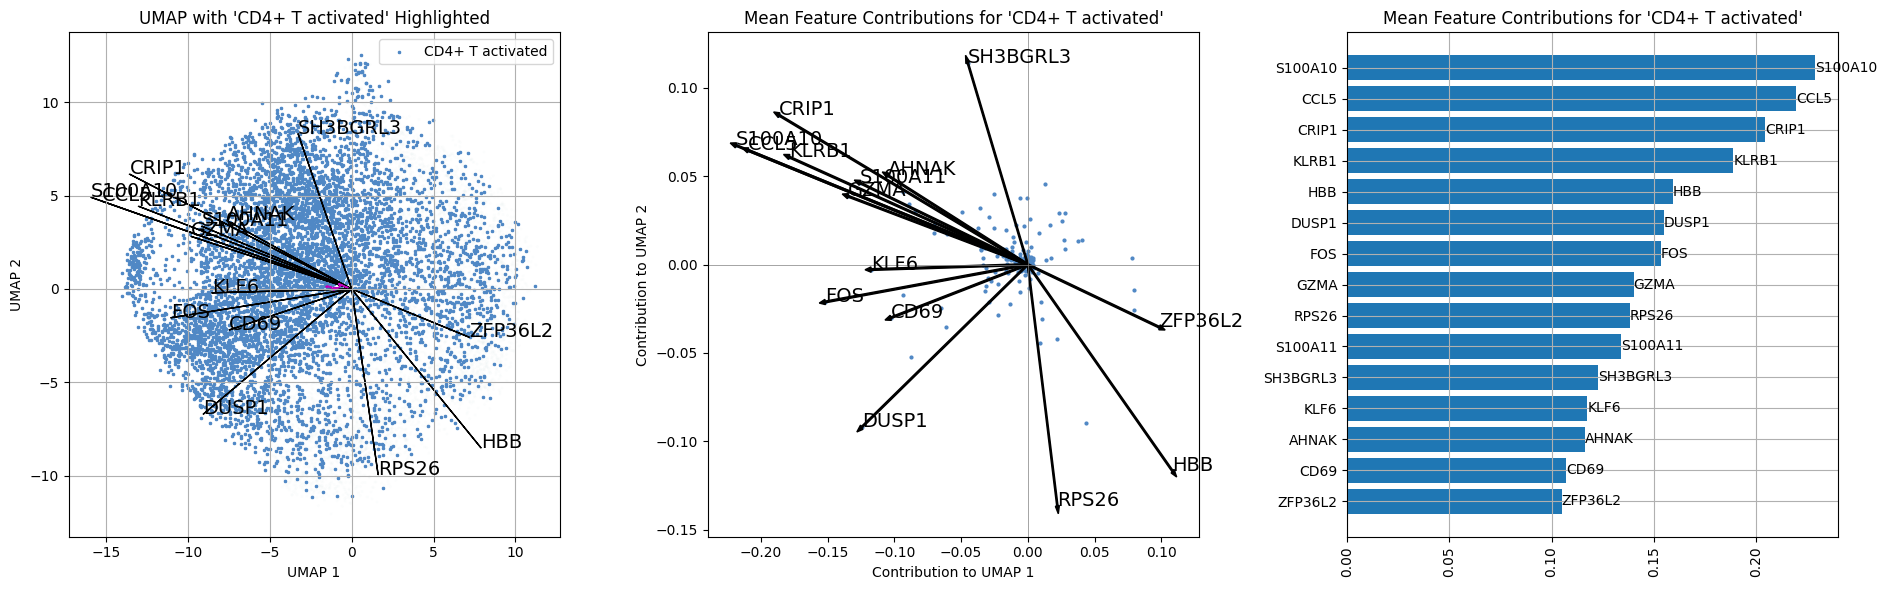


Analyzing cell type: CD4+ T naive


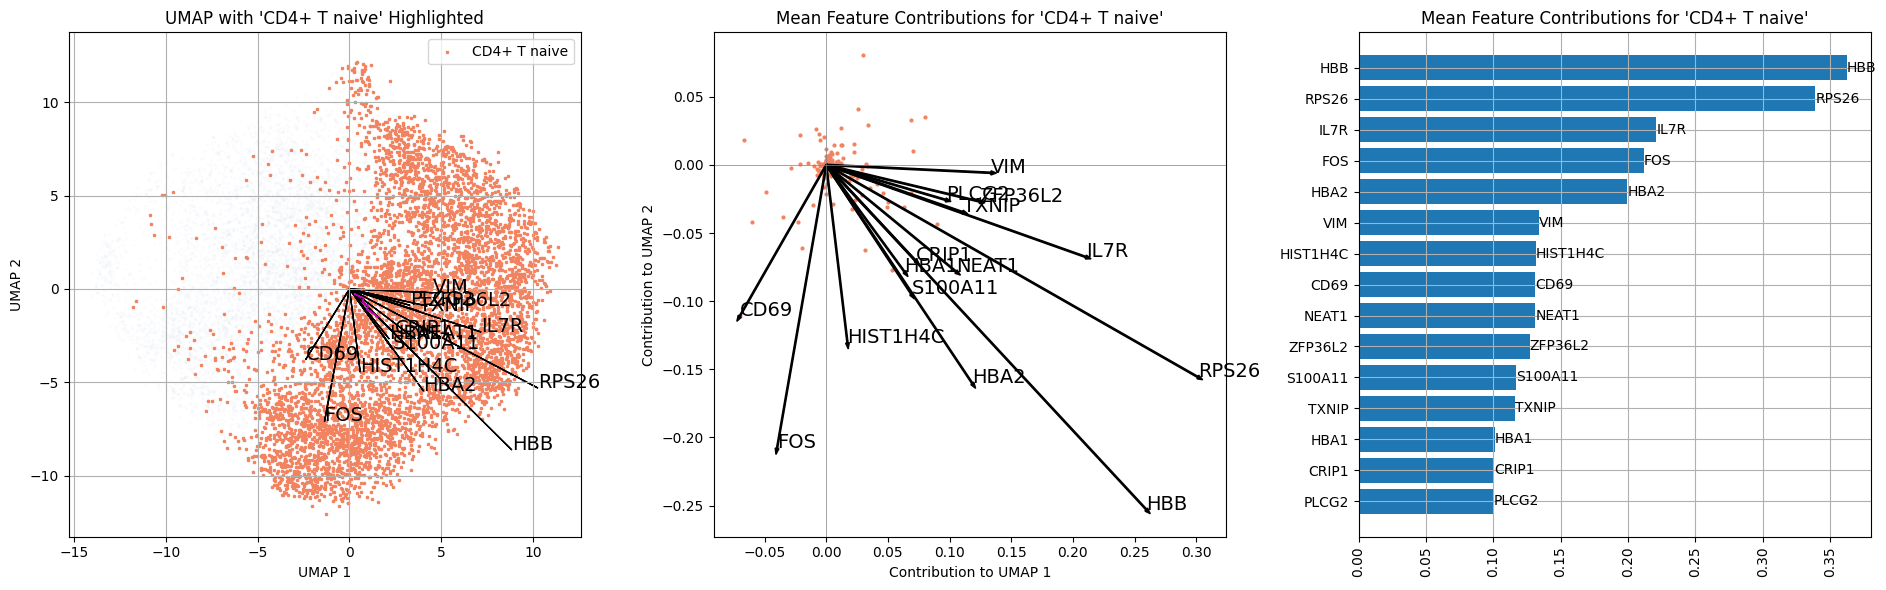

In [19]:
# Step 5: Plot feature importances
class_features,class_genesorted = plot_feature_importance(adata, embedding, jacobxall, celltypes= adata.obs.cell_type.value_counts().index[:],n_features=15,stat='mean')#, **config["plot_params"])

# Step 6: Export results
# export_results(class_genesorted, config["output_filename"])

🎨 Plotting feature importances for cell types...

Analyzing cell type: CD4+ T activated


/home/coder/glass-box-umap/src/analysis/utils_jacobian.py:197: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(embedding[is_cell_type, 0], embedding[is_cell_type, 1], c = category_colors[ci], s=3, marker='x',label=cell_type)
/home/coder/glass-box-umap/src/analysis/utils_jacobian.py:223: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(1*jx0_agg, 1*jx1_agg, s=4, c=category_colors[ci])


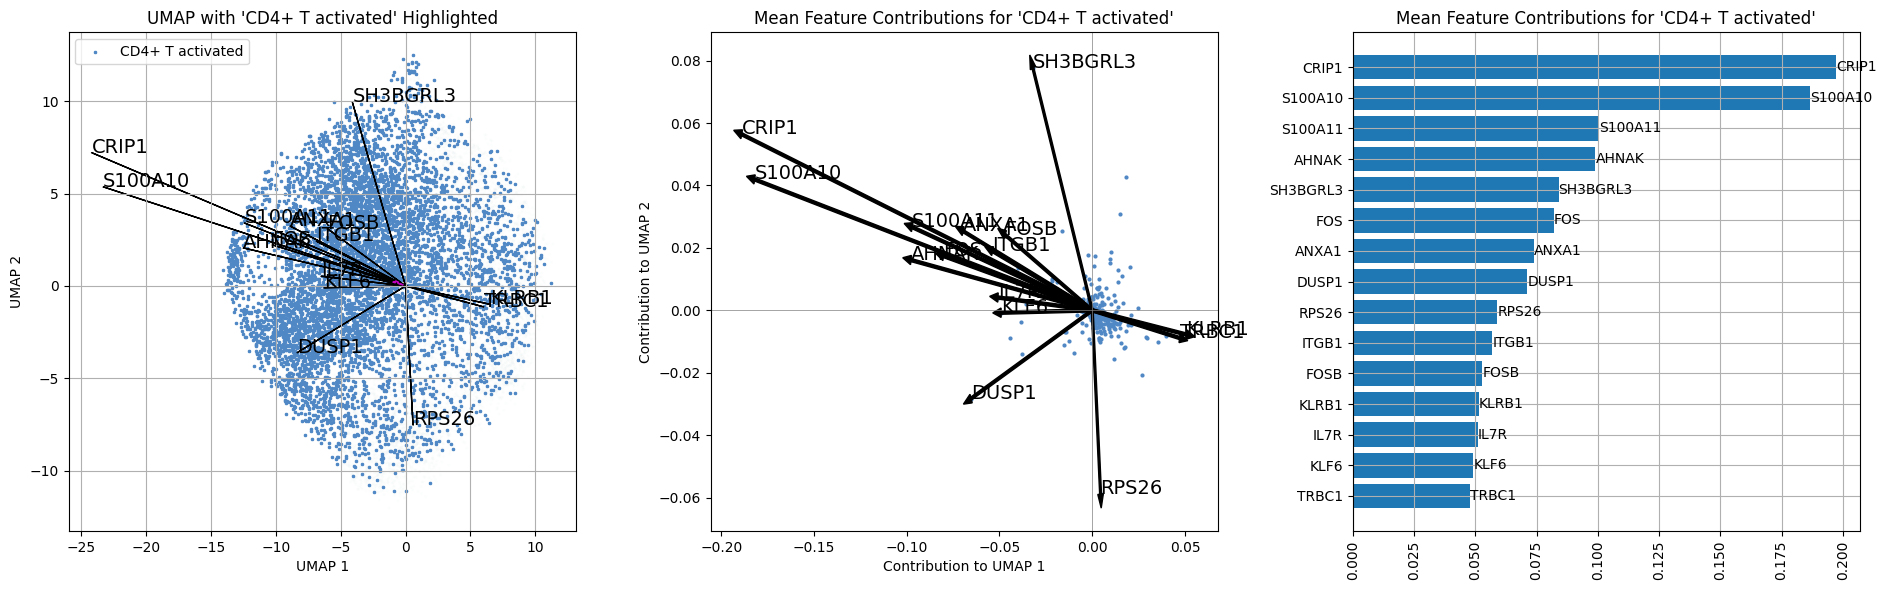


Analyzing cell type: CD4+ T naive


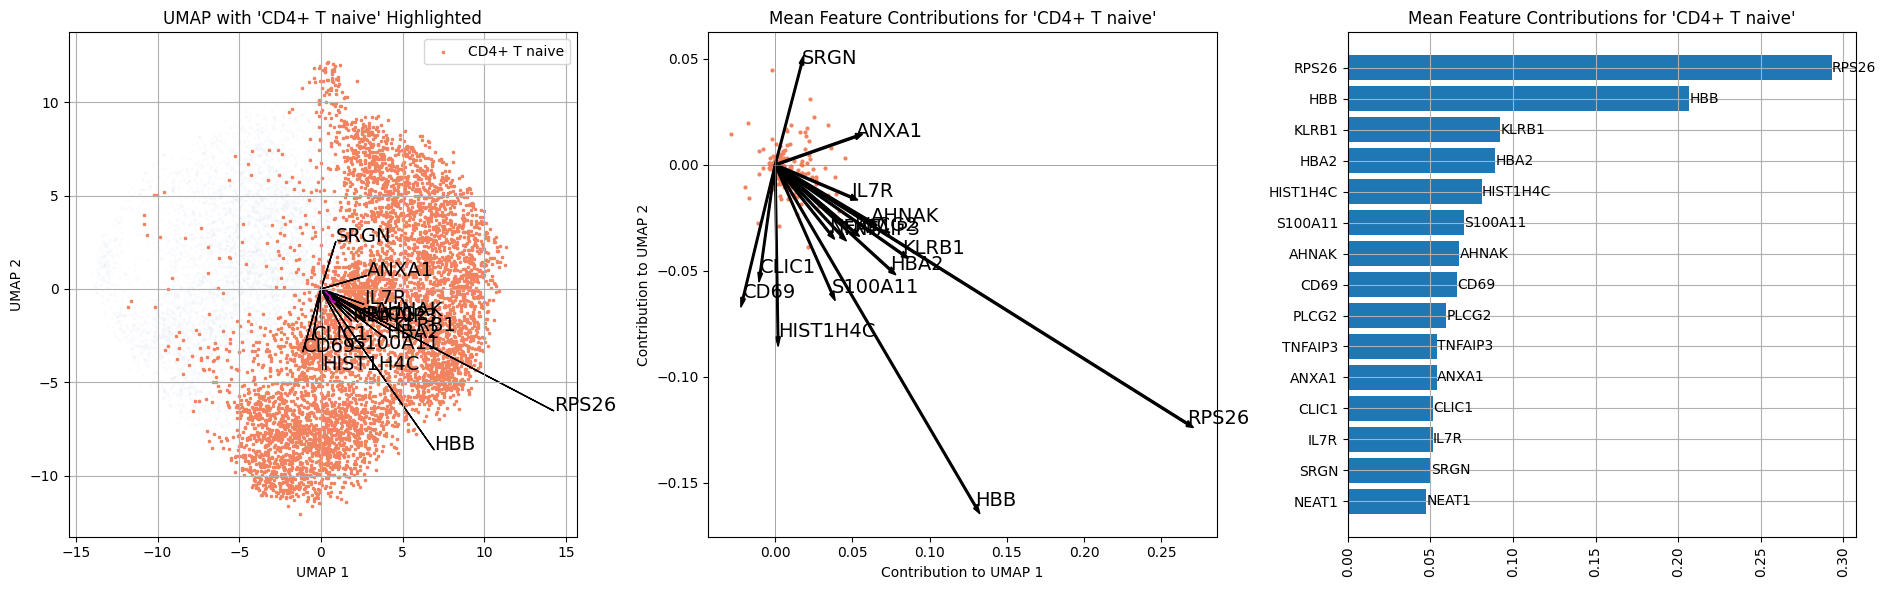

In [18]:
# Step 5: Plot feature importances
class_features,class_genesorted = plot_feature_importance(adata, embedding, jacobxall, celltypes= adata.obs.cell_type.value_counts().index[:],n_features=15,stat='median')#, **config["plot_params"])

# Step 6: Export results
# export_results(class_genesorted, config["output_filename"])